## Introduction of the Project
The project aims to analyze a Coursera dataset to gain insights into various aspects of the courses offered on the platform. The dataset includes information about course ratings, student enrollments, course difficulty, and the course organizations. The primary goal is to explore the distribution of course ratings, understand how different factors such as course difficulty, certificate type, and course organization affect enrollments and ratings, and uncover relationships between these variables.

## Objectives
1. To explore and clean the dataset by identifying missing values, duplicates, and correcting data formats.
2. To analyze the distribution of key variables such as course_students_enrolled, course_rating, and course_difficulty.
3. To identify trends in the dataset, such as which organizations offer the most courses, the most popular certificate types, and which courses have the highest student enrollments.
4. To explore relationships between course ratings, enrollments, and other factors like course difficulty and certificate type.
5. To conduct hypothesis testing (e.g., Tukey's HSD test) to understand the significance of differences in course ratings across difficulty levels.
6. To visualize findings for better interpretation and reporting.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as ss
from scipy import stats
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd
warnings.filterwarnings('ignore')

In [54]:
df = pd.read_csv('coursea_data.csv')

## Exploratory Data Analysis 

In [55]:
# Displaying top 5
df.head(5)

,Unnamed: 0,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
1,743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
2,874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
3,413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
4,635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


In [156]:
df.shape

(891, 7)

In [157]:
#checking the structure of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                891 non-null    int64  
 1   course_title              891 non-null    object 
 2   course_organization       891 non-null    object 
 3   course_Certificate_type   891 non-null    object 
 4   course_rating             891 non-null    float64
 5   course_difficulty         891 non-null    object 
 6   course_students_enrolled  891 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 48.9+ KB


In [56]:
# Dropping column 'Unnamed 0'
df = df.drop(columns=["Unnamed: 0"])

In [57]:
df.shape

(891, 6)

In [7]:
#checking missing values
missing_values = df.isnull().sum()
missing_values

course_title                0
course_organization         0
course_Certificate_type     0
course_rating               0
course_difficulty           0
course_students_enrolled    0
dtype: int64

Our Dataset is free from missing values

In [8]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
duplicates

0

No Duplicates found in our dataset

### Which of the features are categorical?

In [50]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

#print("Categorical columns:", categorical_columns)
for c in categorical_columns:
    print(f"* {c}")

* course_title
* course_organization
* course_Certificate_type
* course_difficulty
* course_students_enrolled


### Which of the features are numeric?

In [44]:
numeric_columns = df.select_dtypes(include=['number']).columns
#print("Numeric columns:", numeric_columns)
for data in numeric_columns:
    print(f"*  {data}")

*  course_rating
*  course_students_enrolled


In [58]:
df['course_students_enrolled'].unique()

array(['5.3k', '17k', '130k', '91k', '320k', '39k', '350k', '2.4k', '61k',
       '12k', '4k', '13k', '11k', '27k', '110k', '6.6k', '540k', '22k',
       '2.9k', '80k', '9.9k', '23k', '9.2k', '78k', '190k', '35k', '29k',
       '14k', '21k', '94k', '69k', '40k', '220k', '150k', '18k', '270k',
       '7.9k', '30k', '36k', '20k', '8.1k', '120k', '71k', '63k', '42k',
       '480k', '97k', '200k', '180k', '4.2k', '310k', '3.9k', '79k',
       '31k', '15k', '10k', '66k', '33k', '56k', '7.3k', '9.7k', '210k',
       '28k', '6.5k', '55k', '2.3k', '8.8k', '88k', '1.9k', '68k', '1.6k',
       '9.5k', '57k', '26k', '84k', '95k', '5.8k', '24k', '67k', '280k',
       '38k', '77k', '510k', '89k', '48k', '160k', '32k', '340k', '82k',
       '790k', '19k', '51k', '4.8k', '37k', '43k', '6.4k', '49k', '240k',
       '46k', '7.8k', '75k', '81k', '140k', '5.5k', '99k', '100k', '3k',
       '830k', '740k', '60k', '96k', '690k', '44k', '4.5k', '8.2k', '16k',
       '300k', '8k', '41k', '54k', '9k', '380k',

In [62]:
# Convert from object to int We have to replace 'k' 1000 and 'm' 1000,000
def convert_enrollment(enrollment):
    if 'k' in enrollment:
        return int(float(enrollment.replace('k', '')) * 1000)
    elif 'm' in enrollment:
        return int(float(enrollment.replace('m', '')) * 1000000)
    else:
        return int(enrollment)

df['course_students_enrolled'] = df['course_students_enrolled'].apply(convert_enrollment)

df['course_students_enrolled'].dtype, df['course_students_enrolled'].head()


(dtype('int64'),
 0      5300
 1     17000
 2    130000
 3     91000
 4    320000
 Name: course_students_enrolled, dtype: int64)

### Checking 'course_students_enrolled' Distribution and normalizing

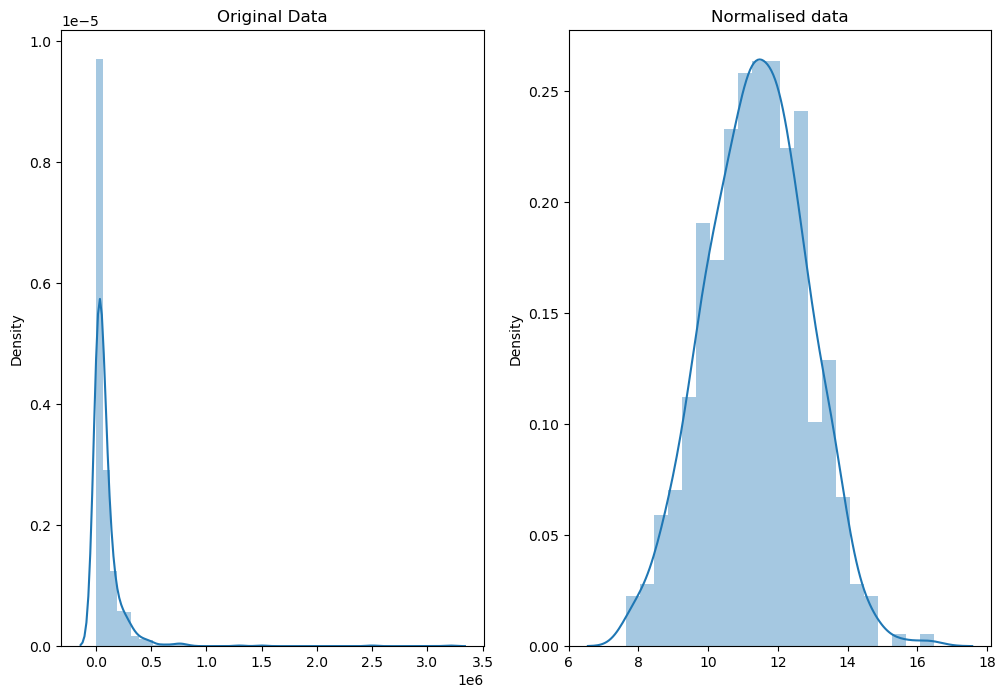

In [63]:
normalized_data, lambda_value = stats.boxcox(df['course_students_enrolled'] + 1)
# Normalise the exponential data with boxcox
normalised_data = stats.boxcox(df['course_students_enrolled'])

# Plot both together to compare
fig, ax=plt.subplots(1,2)
plt.rcParams["figure.figsize"] = [12.00, 8.00]
sns.distplot(df['course_students_enrolled'], ax=ax[0])
ax[0].set_title("Original Data")
ax[0].set(xlabel = '', ylabel='Density')
sns.distplot(normalised_data[0], ax=ax[1])
ax[1].set_title("Normalised data");

- **Original** data is non-normal.
- **Normalized data**  is  a symmetric, bell-shaped curve.
-  The Normalizes the data reduces its skewness, so it follows a bell-shaped, normal-like distribution. 

In [71]:
# Calculate the mean of the normalized data
#mean_normalized = normalized_data.mean()
#mean_normalized

11.379479790126153

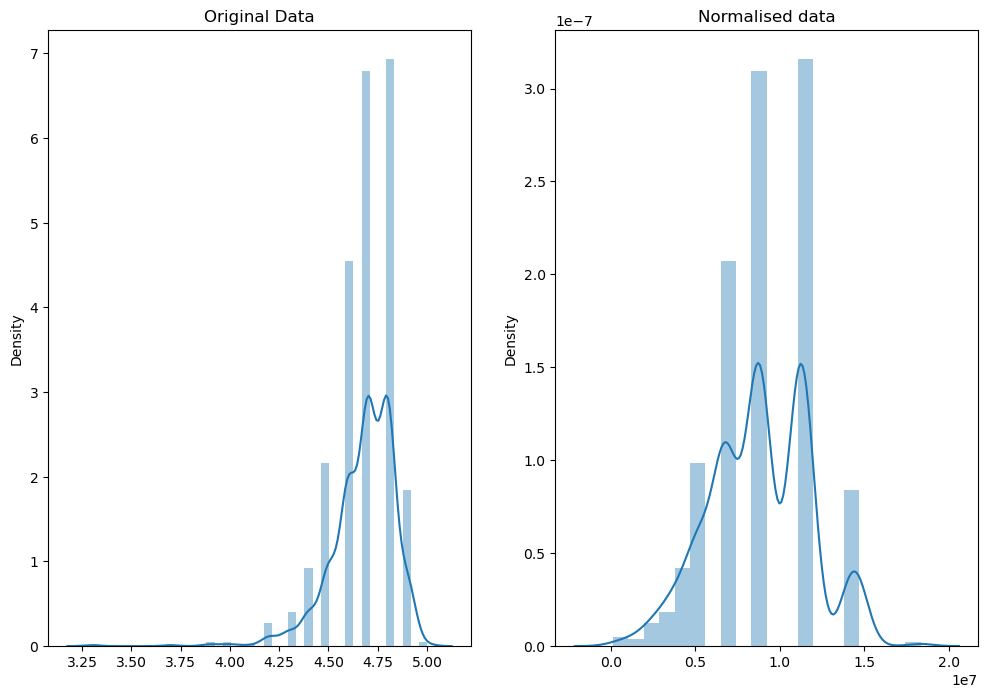

In [20]:
# Normalise the exponential data with boxcox
normalised_data = stats.boxcox(df['course_rating'])
fig, ax=plt.subplots(1,2)
plt.rcParams["figure.figsize"] = [8, 4]
sns.distplot(df['course_rating'], ax=ax[0])
ax[0].set_title("Original Data")
ax[0].set(xlabel = '', ylabel='Density')
sns.distplot(normalised_data[0], ax=ax[1])
ax[1].set_title("Normalised data");

### Checking Outliers

In [23]:
# find the limits
upper_limit = df['course_students_enrolled'].mean() + 3*df['course_students_enrolled'].std()
lower_limit = df['course_students_enrolled'].mean() - 3*df['course_students_enrolled'].std()
print('upper limit:', upper_limit)
print('lower limit:', lower_limit)

upper limit: 636361.4378733009
lower limit: -455257.2852358149


In [73]:
# find the outliers
df.loc[(df['course_students_enrolled'] > upper_limit) | (df['course_students_enrolled'] < lower_limit)]

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
129,Career Success,"University of California, Irvine",SPECIALIZATION,4.4,Beginner,790000
196,Data Science,Johns Hopkins University,SPECIALIZATION,4.5,Beginner,830000
199,Data Science: Foundations using R,Johns Hopkins University,SPECIALIZATION,4.6,Beginner,740000
211,Deep Learning,deeplearning.ai,SPECIALIZATION,4.8,Intermediate,690000
261,English for Career Development,University of Pennsylvania,COURSE,4.8,Mixed,760000
564,Machine Learning,Stanford University,COURSE,4.9,Mixed,3200000
674,Programming for Everybody (Getting Started wit...,University of Michigan,COURSE,4.8,Mixed,1300000
688,Python for Everybody,University of Michigan,SPECIALIZATION,4.8,Beginner,1500000
765,Successful Negotiation: Essential Strategies a...,University of Michigan,COURSE,4.8,Mixed,750000
815,The Science of Well-Being,Yale University,COURSE,4.9,Mixed,2500000


### How many observations and features are there in this dataset?

In [244]:
obs = str(len(df.index))
feat = str(len(df.columns))

print("Observations:", obs )
print("Features: ", feat)

Observations: 891
Features:  6


### How many unique course_organization?

In [59]:
# Checking unique school in dataset
df['course_organization'].nunique()

154

### Which course organizations offer the most courses?

In [74]:
df['course_organization'].value_counts().reset_index(name='count').head(10).reset_index(drop=1)

,course_organization,count
0,University of Pennsylvania,59
1,University of Michigan,41
2,Google Cloud,34
3,Johns Hopkins University,28
4,Duke University,28
5,"University of California, Irvine",27
6,IBM,22
7,University of Illinois at Urbana-Champaign,22
8,"University of California, Davis",21
9,University of Colorado Boulder,19


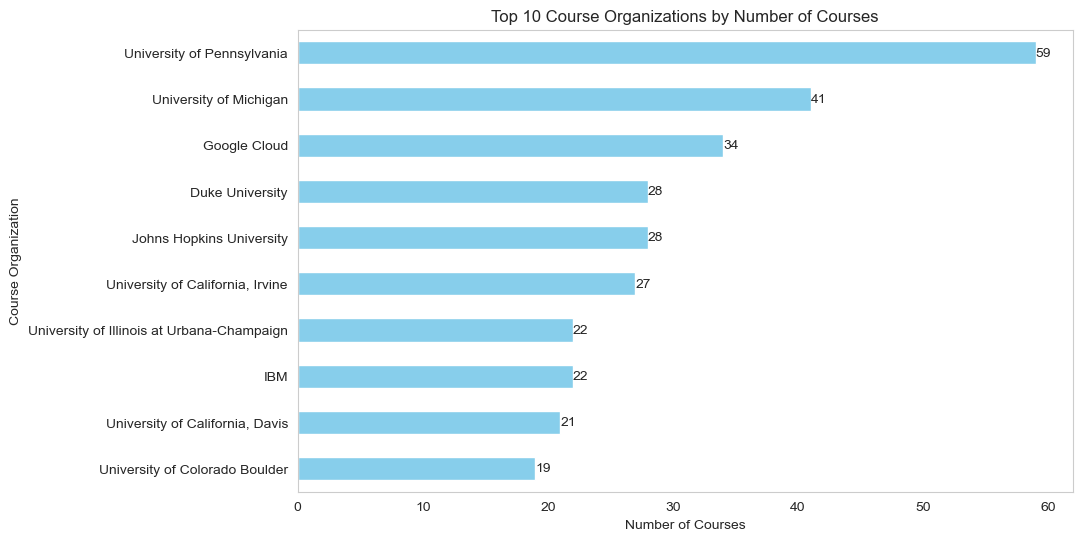

In [209]:
# Group by course_organization and count the number of courses
organization_course_count = df['course_organization'].value_counts()

plt.figure(figsize=(10, 6))
organization_course_count_sorted = organization_course_count.head(10).sort_values(ascending=True)
ax = organization_course_count_sorted.plot(kind='barh', color='skyblue')
plt.title('Top 10 Course Organizations by Number of Courses')
plt.xlabel('Number of Courses')
plt.ylabel('Course Organization')
plt.grid(False) 

for index, value in enumerate(organization_course_count_sorted):
    plt.text(value, index, str(value), va='center', ha='left')

plt.show()


- **University of Pennsylvania** - eads the chart with 59 courses, significantly ahead of other organizations.
- Demonstrates a strong presence in course offerings, possibly indicating a high level of engagement in online education.
  

### What is the proportion of certificate types in the dataset?

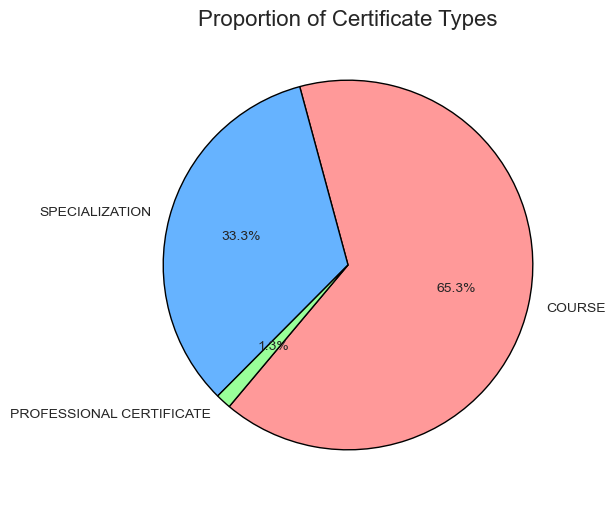

In [222]:
certificate_counts = df['course_Certificate_type'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    certificate_counts, 
    labels=certificate_counts.index, 
    autopct='%1.1f%%', 
    startangle=230, 
    colors=['#ff9999', '#66b3ff', '#99ff99'],
    wedgeprops={'edgecolor': 'black'}
)

plt.title('Proportion of Certificate Types', fontsize=16)

plt.show()

**Most Common Certificate Type:** The majority of courses offer a standard "Course" certificate, suggesting that courses aimed at broader audiences or skill levels are more common.
- The small share of **Professional Certificates (1.3%)** might suggest that fewer courses focus on high-level professional skills, or it may imply the specialized nature of such certifications.

### Distribution of course_difficulty

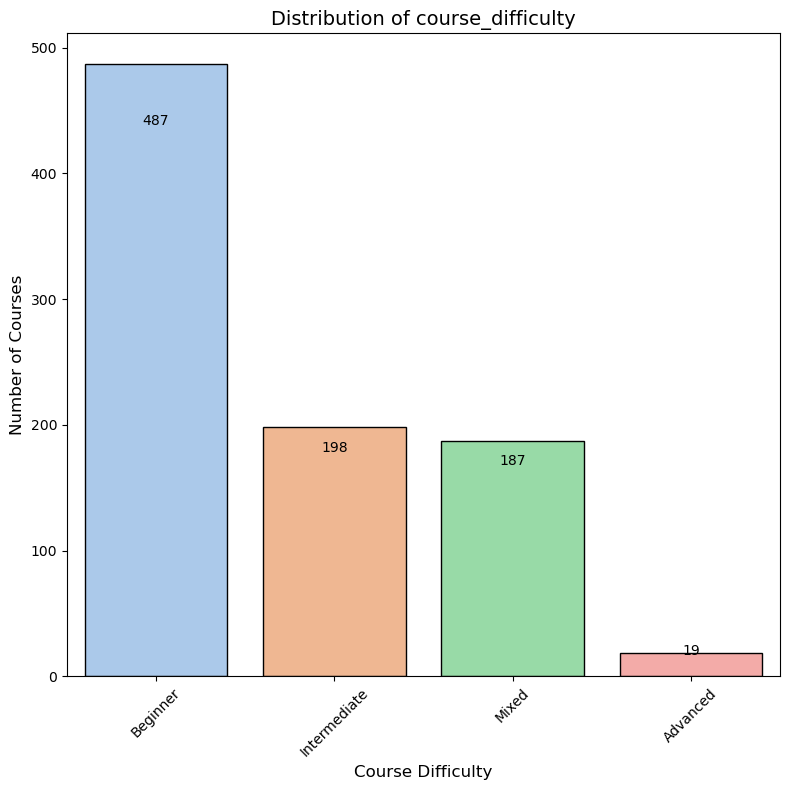

In [27]:
course_difficulty_counts = df['course_difficulty'].value_counts()
plt.figure(figsize=(8,8))
ax = sns.barplot(
    x=course_difficulty_counts.index,
    y=course_difficulty_counts.values,
    palette="pastel",
    edgecolor="black"
)

# Add annotations to each bar
for i, value in enumerate(course_difficulty_counts.values):
    ax.text(
        i,  
        value - (value * 0.1),  
        str(value),  
        color='black', 
        ha='center', 
        fontsize=10
    )

plt.title('Distribution of course_difficulty', fontsize=14)
plt.xlabel('Course Difficulty', fontsize=12)
plt.ylabel('Number of Courses', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


- **Beginner Level:** The most popular difficulty level. A total of 487 courses are classified as beginner-level.
- Indicates a strong focus on entry-level learning materials, likely catering to a wide audience starting a new course.

### What are total count of student enrolled per course difficulity?

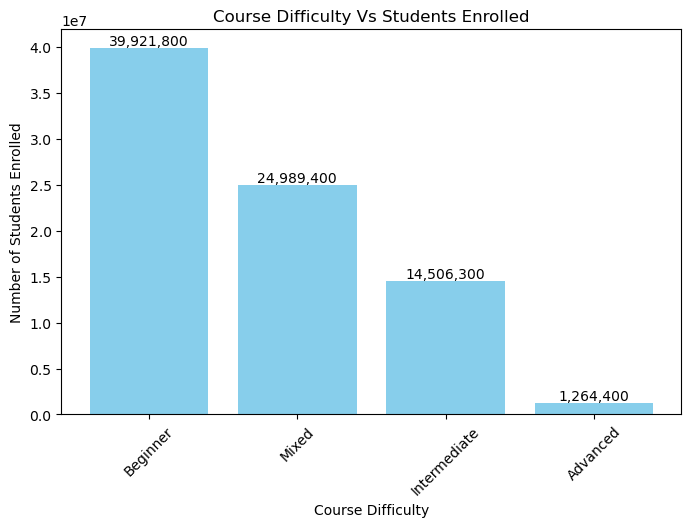

In [75]:
difficulty_enrollment = df.groupby('course_difficulty')['course_students_enrolled'].sum().reset_index()
difficulty_enrollment = difficulty_enrollment.sort_values(by='course_students_enrolled', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(difficulty_enrollment['course_difficulty'], difficulty_enrollment['course_students_enrolled'], color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.title('Course Difficulty Vs Students Enrolled')
plt.xlabel('Course Difficulty')
plt.ylabel('Number of Students Enrolled')
plt.xticks(rotation=45)
plt.show()

- **Beginner:**-The highest enrollment, with 39,921,800 students.
- This confirms that beginner courses attract the largest audience, likely because they cater to learners starting new skills or subjects.

### Top 10 Course organization per number of student enrolled

In [79]:
organization_enrollment_df = df.groupby('course_organization')['course_students_enrolled'].sum().reset_index()

# Sort the DataFrame by the total number of students enrolled
organization_enrollment_df = organization_enrollment_df.sort_values(by='course_students_enrolled', ascending=False)                                                    
top_10_organizations = organization_enrollment_df.head(10)
#top_10_organizations

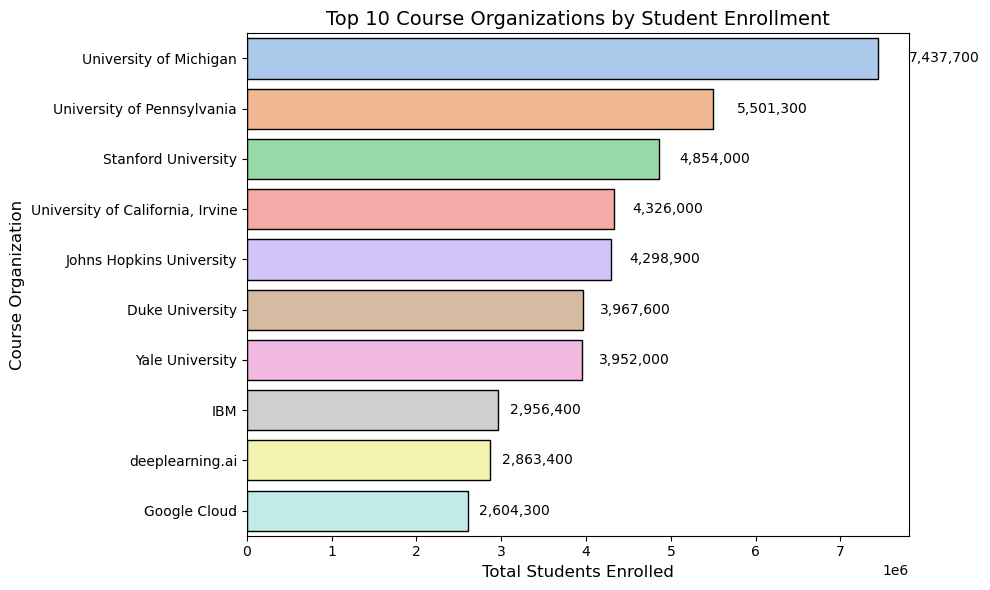

In [77]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=top_10_organizations['course_students_enrolled'],  
    y=top_10_organizations['course_organization'],       
    palette="pastel",
    edgecolor="black",
    orient='h'
)

for i, value in enumerate(top_10_organizations['course_students_enrolled']):
    ax.text(
        value + (value * 0.05),  
        i,  
       f'{value:,.0f}',  
        color='black', 
        va='center', 
        fontsize=10
    )

plt.title('Top 10 Course Organizations by Student Enrollment', fontsize=14)
plt.xlabel('Total Students Enrolled', fontsize=12)
plt.ylabel('Course Organization', fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()


**University of Michigan:** - The leader in student enrollment with 7,437,700 students.
- This indicates a strong reputation and broad appeal, likely driven by diverse and high-quality courses.

- **University of Pennsylvania:** Ranked second with 5,501,300 students.

### Which courses have the highest enrollment numbers?

In [40]:
course_enrolled_df = df.groupby('course_title')['course_students_enrolled'].sum().reset_index()

course_enrolled_df = course_enrolled_df.sort_values(by='course_students_enrolled', ascending=0)

course_enrolled_df

top_10_course_enrolled = course_enrolled_df.head(10)
#top_10_course_enrolled

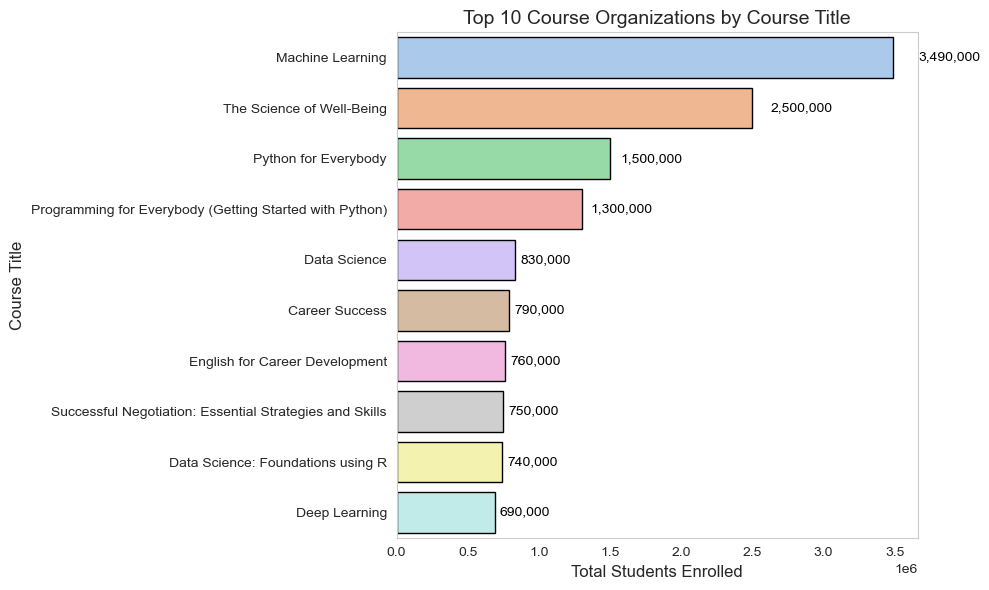

In [78]:
sns.set_style("whitegrid")

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=top_10_course_enrolled['course_students_enrolled'],  
    y=top_10_course_enrolled['course_title'],       
    palette="pastel",
    edgecolor="black",
    orient='h'
)

for i, value in enumerate(top_10_course_enrolled['course_students_enrolled']):
    ax.text(
        value + (value * 0.05), 
        i,  
        f'{value:,.0f}',   
        color='black', 
        va='center', 
        fontsize=10
    )

plt.title('Top 10 Course Organizations by Course Title', fontsize=14)
plt.xlabel('Total Students Enrolled', fontsize=12)
plt.ylabel('Course Title', fontsize=12)
plt.tight_layout()
plt.grid(False)

plt.show()


- **Machine Learning** Dominates: The course leads with 3.49 million students, highlighting the growing demand for skills in AI and data science.
- These trends offer valuable insights into the current educational landscape and can guide institutions and learners in prioritizing relevant skills and knowledge areas.

### Checking the relationship between course_difficulty and course_rating

In [91]:
# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(df['course_rating'], df['course_difficulty'])
print(tukey_result.summary())


      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
    Advanced     Beginner   0.0809 0.1378 -0.0159 0.1777  False
    Advanced Intermediate   0.0465 0.6249 -0.0529 0.1459  False
    Advanced        Mixed   0.1086 0.0265  0.0089 0.2082   True
    Beginner Intermediate  -0.0344 0.0545 -0.0693 0.0004  False
    Beginner        Mixed   0.0277  0.189  -0.008 0.0633  False
Intermediate        Mixed   0.0621 0.0009  0.0199 0.1043   True
---------------------------------------------------------------


- At 95% confidence interval.
  
- **p-adj:** The adjusted p-value after correcting for multiple comparisons. If this value is less than 0.05, it indicates that the difference between the two groups is statistically significant.
- **reject:** If this column shows True, it means there is a statistically significant difference between the two groups (p-adj < 0.05). If False, there is no significant difference.

- There is **no significant difference** in ratings between **Advanced and Beginner**, **Advanced and Intermediate**, **Beginner and Intermediate**, or **Beginner and Mixed**
- There are some **significant differences** in course ratings (particularly between **Advanced vs Mixed** and **Intermediate vs Mixed**), not all difficulty levels show significant differences from each other.

**Key Insights**
Significant differences exist between:
- **Advanced vs. Mixed** 
- **Intermediate vs. Mixed**
No significant differences were observed in other pairwise comparisons.
- These findings suggest that the "Mixed" group has ratings that differ meaningfully from both "Advanced" and "Intermediate." Further investigation may be needed to understand why.

### What is the distribution of course ratings?

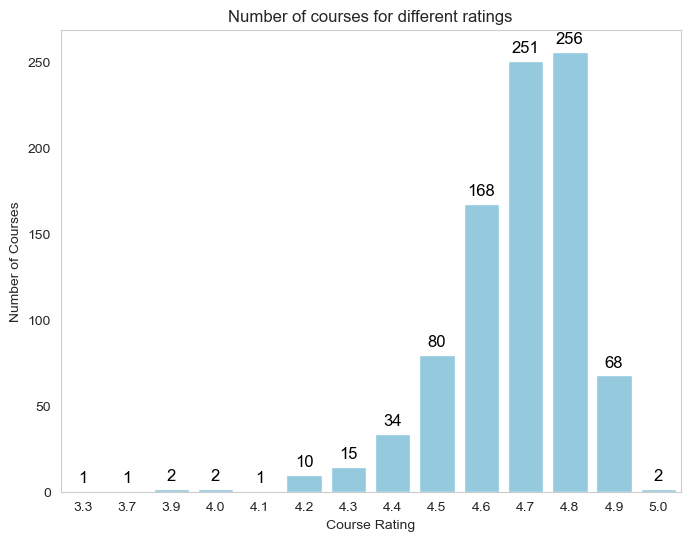

In [240]:
plt.figure(figsize=(8,6)) 
ax = sns.countplot(x='course_rating', data=df, color='skyblue')  

sns.set_style("whitegrid")
plt.xlabel('Course Rating')
plt.ylabel('Number of Courses')
plt.grid(False)
plt.title('Number of courses for different ratings')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 9), textcoords='offset points')

plt.show()


- High Ratings Dominance: The chart shows that the majority of courses are highly rated, with most courses falling within the **4.6 to 4.8** rating range. This suggests a general satisfaction among users with the quality of courses offered.
- The highest number of courses, **256, have a rating of 4.8.** This peak indicates that many courses are perceived as excellent by users, hinting at a high standard of educational content and delivery.



### How does the certificate type affect the average course rating?

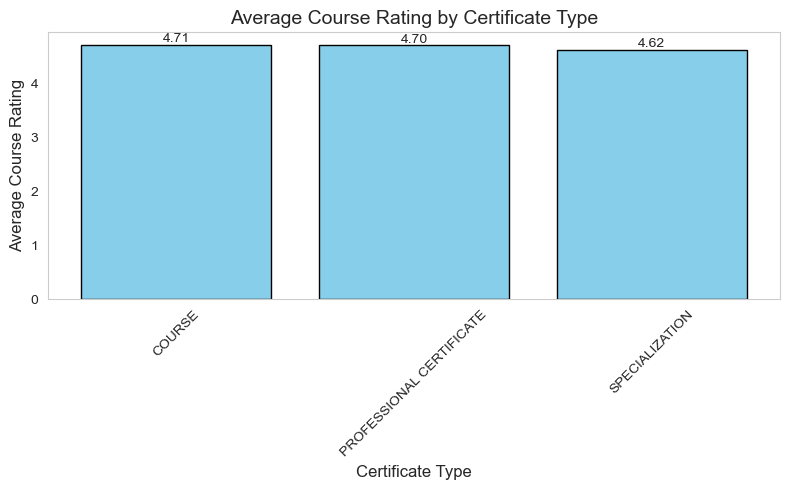

In [180]:
avg_ratings = df.groupby('course_Certificate_type')['course_rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
bars = plt.bar(avg_ratings.index, avg_ratings.values, color='skyblue', edgecolor='black')

# Adding annotations on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{height:.2f}', ha='center', fontsize=10)

# Adding title and labels
plt.title('Average Course Rating by Certificate Type', fontsize=14)
plt.xlabel('Certificate Type', fontsize=12)
plt.ylabel('Average Course Rating', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

- Overall High Ratings: All certificate types have high average ratings, indicating that learners generally have a positive experience across the board.

### Which course difficulty level has the highest average rating?

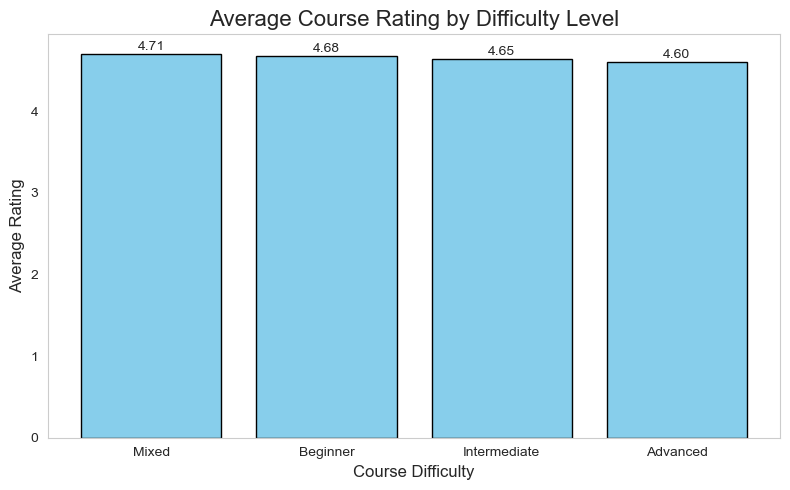

In [241]:
avg_difficulty_rating = df.groupby('course_difficulty')['course_rating'].mean().sort_values(ascending=False)

# Plotting a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(avg_difficulty_rating.index, avg_difficulty_rating.values, color='skyblue', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{height:.2f}', ha='center', fontsize=10)

plt.title('Average Course Rating by Difficulty Level', fontsize=16)
plt.xlabel('Course Difficulty', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

- Overall High Ratings: All course_difficulty types have high average ratings, indicating that learners generally have a positive experience across the board.

### What are the top organizations in terms of average student enrollment?

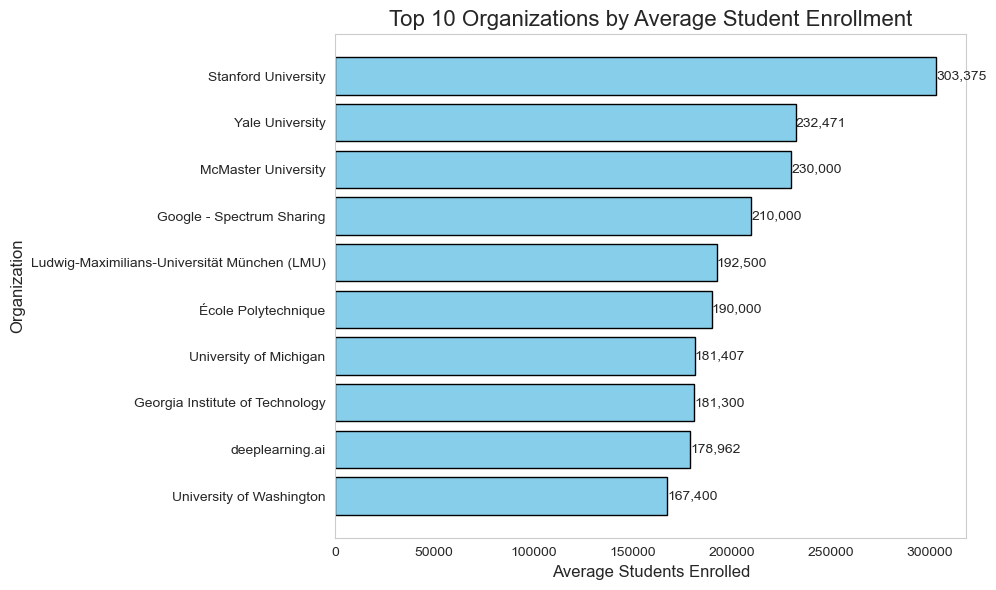

In [242]:
avg_enrollment = df.groupby('course_organization')['course_students_enrolled'].mean().sort_values(ascending=False)

top_organizations = avg_enrollment.head(10)

top_organizations = top_organizations[::-1]

plt.figure(figsize=(10, 6))
bars = plt.barh(top_organizations.index, top_organizations.values, color='skyblue', edgecolor='black')

# Adding annotations to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 100, bar.get_y() + bar.get_height() / 2, f'{width:,.0f}', va='center', fontsize=10)

plt.title('Top 10 Organizations by Average Student Enrollment', fontsize=16)
plt.xlabel('Average Students Enrolled', fontsize=12)
plt.ylabel('Organization', fontsize=12)
plt.xticks(fontsize=10)
plt.grid(False)

plt.tight_layout()
plt.show()

- **Stanford University** leads with an impressive average student enrollment of 303,375, highlighting its strong reputation and wide appeal.

- **Yale University** and **McMaster University** follow closely with 232,471 and 230,000 students respectively, indicating their significant influence in online education.

### Is there a relationship between course ratings and the number of students enrolled?

In [200]:
# Calculating Pearson correlation coefficient
correlation = df['course_rating'].corr(df['course_students_enrolled'])
print(f'Pearson Correlation Coefficient: {correlation:.2f}')


Pearson Correlation Coefficient: 0.07


- 0.07 is very close to 0, indicating a very weak positive correlation between the course ratings and the number of students enrolled.
- There isn't a strong relationship between course ratings and the number of students enrolled. While higher ratings might attract more students, this effect is minimal based on the data shown.

### Which organization has the highest course rating by average?

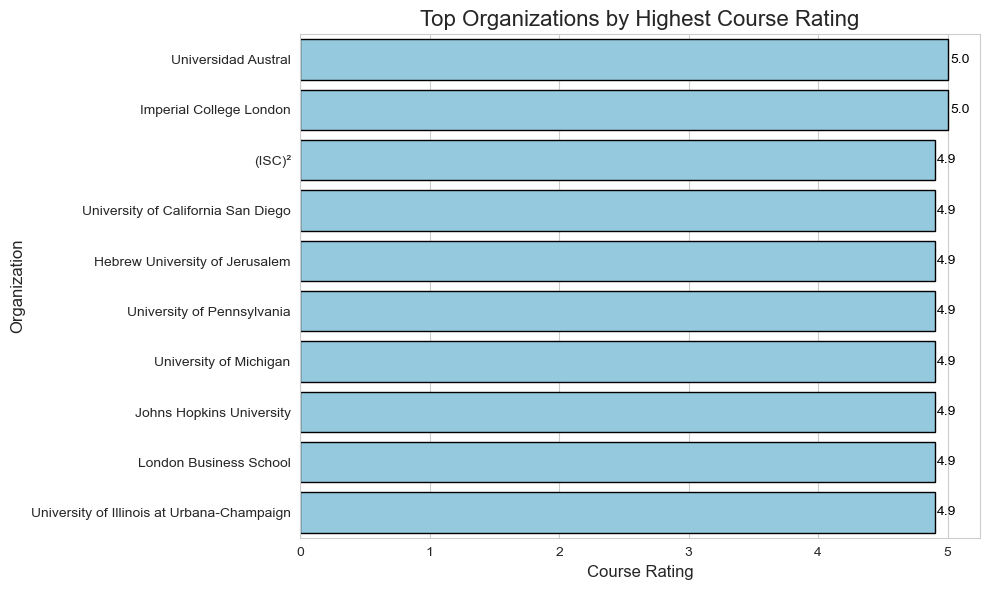

In [228]:
top_rated_organization = df.groupby('course_organization')['course_rating'].max()

# Sorting values in descending order and selecting the top 10
top_rated_organization = top_rated_organization.sort_values(ascending=False).head(10)

# Creating the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    y=top_rated_organization.index,  
    x=top_rated_organization.values,
    color='skyblue',
    edgecolor='black'
)


for i, value in enumerate(top_rated_organization.values):
    ax.text(
        value + 0.02,  
        i, 
        f'{value:.1f}',  
        ha='left', 
        va='center',
        fontsize=10, 
        color='black'
    )

# Adding title and labels
plt.title('Top Organizations by Highest Course Rating', fontsize=16)
plt.xlabel('Course Rating', fontsize=12)
plt.ylabel('Organization', fontsize=12)
plt.tight_layout()
plt.show()



- **Universidad Austral and Imperial College London** lead with perfect course ratings of 5.0. This indicates that their courses are highly esteemed by students, reflecting exceptional quality and satisfaction.

## Insights/Findings
1. **Missing Values & Duplicates:** No missing values or duplicates were found in the dataset.
2. **Course Enrollments:** After converting the course_students_enrolled column to numeric values, the data was normalized using the Box-Cox transformation to handle the skewness.
3. **Top Organizations:** The University of Pennsylvania and the University of Michigan offer the most courses, with 59 and 41 courses respectively. Other prominent organizations include Google Cloud with 34 courses.
4. **Certificate Type Distribution:** The majority of courses are labeled as "COURSE" (65.3%), followed by "SPECIALIZATION" (33.3%), and a smaller percentage of "PROFESSIONAL CERTIFICATE" courses (1.3%).
5. **Course Difficulty:** The distribution shows that most courses are classified as "BEGINNER" (487 courses), followed by "INTERMEDIATE" (198 courses), "MIXED" (187), and "ADVANCED" (19).
6. **Enrollment by Difficulty:** "BEGINNER" courses have the highest total enrollment (39.9 million), followed by "INTERMEDIATE" (24.99 million), and "MIXED" (14.5 million).
7. **Top Courses by Enrollment:** "Machine Learning" leads with 3.49 million enrollments, followed by "The Science of Well-Being" and "Python for Everybody" with 2.5 million and 1.5 million enrollments, respectively.
8. **Outliers:** The dataset contained 10 outliers based on student enrollments, but these were not removed as they appeared reasonable.
9. **Course Rating Distribution:** Most courses have ratings between 4.6 and 4.8, with a few exceptional ratings of 4.9.
10. **Course Difficulty vs. Rating:** Mixed courses tend to have the highest average rating (4.71), while Advanced courses have the lowest average rating (4.60).
11. **Correlation:** There is a weak positive correlation (0.07) between course ratings and the number of students enrolled.

### Project Summary & Future Improvements
The analysis provided a comprehensive view of the Coursera dataset, highlighting key trends such as the relationship between course difficulty, certificate types, and course ratings. By normalizing the course_students_enrolled data and handling outliers, the analysis ensured that the results were reliable and accurate. 

**Conclusion**
- The project successfully analyzed various aspects of Coursera courses, uncovering useful insights into course offerings, enrollment patterns, and course ratings. While there are clear trends in course difficulty and enrollment, the weak correlation between course ratings and enrollments suggests that other factors, such as course content or marketing, may play a more significant role in influencing student engagement. Overall, the analysis provides a solid foundation for understanding the dynamics of online learning platforms like Coursera.